In [3]:
!wget https://raw.githubusercontent.com/dui1234/JAX_HNN/main/interp.py -q

In [4]:
!wget https://raw.githubusercontent.com/dui1234/JAX_HNN/main/loop.py -q

In [5]:
pip install jaxopt -q

     |████████████████████████████████| 125 kB 8.7 MB/s 


In [154]:
from jax.config import config; config.update("jax_enable_x64", True)
import jax
import jax.numpy as np
import interp
import matplotlib as mpl
import matplotlib.pyplot as plt
import jaxopt
from functools import partial
from jax.experimental import ode
from jax import jit,grad,vmap
from loop import while_loop
import timeit

In [7]:
def time_mirroring(t0,t1):
    """Time mirroring function for backward integration 
    Args:
        ts : tim grid
    Returns:
        function t->t to reverse/mirorr times 
    """
    return lambda t : t1 - t - t0 # time flip function

def optimal_control_setup(*,f,g,gbc,control,mixing,iter_crit,ts,x0,state_interpolator,control_interpolator):
    """
    Generate FBS solution to optimal control problem given state and value dynamics
        dx = f(t,x,u)
        dλ = g(t,x,u,λ)
    
    Args:
        f         : constraint dynamics t -> x -> u -> x'
        g         : value dynamics      t -> x -> u -> λ -> λ'
        gbc       : value boundary cond t -> x -> u -> λ
        control   : optimal control     t -> x -> λ -> u
        mixing    : mixing function     u -> u -> u
        iter_crit : iteration condition a -> a -> bool
        [ts]      : time grid over which solution should be generated (function interpolation points)
        x0        : initial condition for x
        state_interpolator   : x interpolator [t] -> ([x] -> t -> x)
        control_interpolator : u interpolator [t] -> ([u] -> t -> u)
        
    Returns:
        init  : u -> ([x],[λ],[u])
        cond  : ([x],[λ],[u]) -> ([x],[λ],[u]) -> bool
        body  : ([x],[λ],[u]) -> ([x],[λ],[u])
    """
    xinterp = state_interpolator(ts)         # x interpolating function
    uinterp = control_interpolator(ts)       # u interpolating function
    tflip   = time_mirroring(ts[0], ts[-1])  # time grid for reverse integration
    utrj    = vmap(control, in_axes=(0,0,0)) # mapped optimal control function
    
    # define ode rhs functions with odeint signature : x->t->*args->xdot 
    def dx(x,t,us): # forward integration
        """state dynamics θ->t->[k]->θ'
        """
        return f(t, x, uinterp(us, t)) 

    def dλ(λ,t,xs,us) : # backward integration
        """value dynamics λ->t->[x]->[u]->λ'
        """
        tprime = tflip(t)
        return -g(tprime, xinterp(xs, tprime), uinterp(us, tprime), λ)
    
    def body(val):
        """ Body function to perform one-sweep of the FBS algorithm
            ([x],[λ],[u]) -> ([x],[λ],[u])
        Args:
            val : tuple of values for x,λ,u
        Returns:
            val : updated tuple of values for x,λ,u
        """
        xs,λs,us = val
        # forward integration t:(0, Tmax)
        xs = ode.odeint(dx, x0, ts, us)
        # backward integration t:(Tmax, 0)
        λf= gbc(ts[-1],xs[-1], us[-1])
        λs= ode.odeint(dλ, λf, tflip(ts)[::-1], xs, us)[::-1]
        # update control
        us = mixing(us, utrj(ts, xs, λs))
        return xs, λs, us
    
    def init():
        """Initialization condition used to generate proper size/shape initial guesses
        """
        tshape = ts.shape
        xshape = tshape + np.array(x0).shape
        def func(k0):
            """Initialization function k->([θ],[λ],[k])"""
            k0 = np.array(k0)
            return np.zeros(xshape), np.zeros(xshape), np.ones(tshape+k0.shape)*k0  # x,λ,u
        return func

    def cond(val, newval):
        """ Continuation criteria for FBS 
            ([x],[λ],[u]) -> ([x],[λ],[u]) -> bool

        Checks convergence of x AND u
            Δiter(x,xnew) > δ and Δiter(u,unew) > δ

        Args:
            val   : old solution
            newval: new solution
        Returns:
            bool : True (iterations should continue) or False (iterations should stop = converged)
        """
        x,_,u       = val
        xnew,_,unew = newval
        return np.logical_and(iter_crit(x,xnew), iter_crit(u,unew))
    
    return init(), cond, body

In [8]:
def nashify(fun):
    """Nashified function, evaluated at θ=ψ, k=ϰ
    Args :
        fun : t -> θ -> ψ -> k -> ϰ -> *args -> x
    Returns:
        newfun : t -> θ -> k -> *args -> x
    """
    return lambda t,θ,k,*args : fun(t,θ,θ,k,k,*args)
def negative(fun):
    return lambda *args : -fun(*args) 
def square(fun):
    return lambda *args : np.linalg.norm(fun(*args))
def identity(fun):
    return lambda *args : fun(*args)

In [9]:
def simon(a, f, β, kstar):
    """Hard-coded functions for Simon's optimal control problem
        V(t,θ,ψ,k,ϰ) = 1/f^t [- a(θi) ψi - β (ϰ - kstar)^2]
        
        Args:
            a : cost of infection function i -> α
            f : individual discount factor
            β : lockdown cost factor
            kstar : baseline behaviour

        Returns:
            (dθ, dλ, λbc, kopt), (constraint, payoff, salvage)

            dθ     : t -> θ -> k -> θ'
            dλ     : t -> θ -> k -> λ -> λ'
            λbc    : t -> θ -> k -> λ
            kopt   : t -> θ -> λ -> k
            
            constraint: t -> θ -> ψ -> k -> ϰ -> ψ'
            payoff    : t -> θ -> ψ -> k -> ϰ -> v
            salvage   : t -> θ -> ψ -> k -> ϰ -> w
    """
    def ψfun(t, θ, ψ, k, ϰ): 
        """Individual state dynamics t->θ->ψ->k->ϰ->ψ'
        """
        s,i   = θ
        ψs,ψi = ψ
        return np.array([-ϰ*ψs*i, ϰ*ψs*i - ψi])    
    θfun = nashify(ψfun)
    def λfun(t, θ, k, λ):
        """Value dynamics t->θ->k->λ->λ' 
        """
        s,i   = θ
        λs,λi = λ
        return np.array([(λs - λi)*k*i, f**(-t)*a(i) + λi])
    def λbc(t, θ, k):
        """Value end boundary conditions t->θ->k->λ
        """
        return np.array([0.0, -f**(-t)*a(0.0)/(1 + np.log(f))])
    def kopt(t, θ, λ):
        """Optimal control t->θ->λ->k
        """
        s,i = θ
        λs,λi = λ
        return np.clip(kstar - f**t/2*(λs-λi)*s*i, a_min = 0.0)
    def payoff(t, θ, ψ, k, κ):
        s,i   = θ
        ψs,ψi = ψ
        return f**(-t)*(-a(i)*ψi - β*(ϰ - kstar)**2)
    def salvage(t, θ, ψ, k, ϰ):
        _, ψi = ψ
        return -f**(-t)*a(0.0)*ψi/(1 + np.log(f))
    return (θfun, λfun, λbc, kopt), (ψfun, payoff, salvage)

def mixfun(post, weight):
    """ Returns mixing function kold -> knew -> knew
        knew = (1-weight)*kold + weight*new
    """
    def fun(k,knew):
        k = post((1.0-weight)*k + weight*knew)
        return k
    return fun

def iteration_criteria(δ):
    def fun(val, newval):
        """ Iteration continuation criterium. 
        Checks if Δiter(val,newval) = |newval - val| / |newval| > δ
        Args:
            val   : old values
            newval: new values
        """
        return δ*np.linalg.norm(newval, ord=1) - np.linalg.norm(newval-val, ord=1) < 0
    return fun

In [31]:
def constrainedEL(state_index=1, control_index=2):
    """EL generatting function
        Args:
            state_index : coordinate position
            control_index: control variable position
    """
    def fun(V,W,F):
        """Dynamics for constrained EL optimal control problem
        Args:
            F : dynamic constraints   a1->a2->...->an->f
            V : cost/payoff function  a1->a2->...->an->v
            W : salvage function      a1->a2->...->an->w
            state_index   : argument position for constrained coordinates (1,...,n)
            control_index : argument position for control parameter (1,...,n)
        Returns:
            dλ   : lagrange multiplier dynamics a1->...->an->λ->λ'
            λbc  : boundary function for λ      a1->...->an->λ
            kopt : optimality condition         a1->...->an->λ->c
                   kopt = 0 at the optimal control
        """
        def lagrangian(*args):
            """Augmented Lagrangian/Hamiltonian L'(...,λ) = V(...) + λ.F(...) """
            return V(*args[:-1]) + np.dot(args[-1], F(*args[:-1]))

        return F, negative(grad(lagrangian, argnums=state_index)), negative(grad(W, argnums=state_index)), grad(lagrangian, argnums=control_index)
    return fun

def nashEL(V,W,F):
    """Given cost/payoff function,  for the population/individual optimal control problem, return EL equations under Nash equiblirum
    Args:
        V cost       : t -> θ -> ψ -> k -> ϰ -> ... -> v
        W salvage    : t -> θ -> ψ -> k -> ϰ -> ... -> w
        F constraint : t -> θ -> ψ -> k -> ϰ -> ... -> f
    Returns:
        dθ   : t -> θ -> k -> ... -> θ'
        dλ   : t -> θ -> k -> ... -> λ -> λ'
        λbc  : t -> θ -> k -> ... -> λ        
        kopt : t -> θ -> k -> ... -> λ -> c
    """
    _, dλ,λbc,kopt = constrainedEL(2,4)(V,W,F)
    return nashify(F), nashify(dλ), nashify(λbc), nashify(kopt)

def optimal_control(optimality,optimizer,**kwargs):
    """Return optimal control function generator given optimality condition
    Args:
        optimality : t->x->u->...-> c (=0 for optimal control)
        optimizer  : jaxopt optimizer
        kwargs     : kwargs for jaxopt optimizer
    Returns:
        uopt u0 -> (t->x->...->λ->u)
    """
    solver = optimizer(fun = lambda u,t,x,*args : optimality(t,x,u,*args), **kwargs)
    def solver_guess(guess):
        u0 = np.array(guess)
        def fun(t,x,*args):
            opt, _ = solver.run(u0, t, x, *args)
            return opt
        return fun
    return solver_guess

def solver(*, f, g, gbc, control, times, x0, uguess, mixing, state_interpolator, control_interpolator, unroll, jit, maxiter=1000):
    """Solve optimal control problem given state and value dynamics and boundary conditons
    Args:
        f                   : state dynamics
        g                   : value dynamics
        gbc                 : value end-boundary conditions
        times               : [ts] values for solution
        x0                  : initial state
        uguess              : control guess
        mixing              : mixing function for control
        state_interpolator  : interpolation function for states
        control_interpolator: interpolation function for control
    """
    init, cond, body = optimal_control_setup(f=f, g=g, gbc=gbc, control=control, \
                                             mixing=mixing, iter_crit=iteration_criteria(1e-6), \
                                             ts=times, x0 = np.array(x0),\
                                             state_interpolator=state_interpolator,\
                                             control_interpolator=control_interpolator)
    solver = while_loop(cond, body, unroll=unroll, jit=jit)
    (x,λ,u), conv, nit = solver(init(uguess), maxiter)
    print(f"Converged = {conv}, Iterations = {nit:4d}")
    return (x,λ,u), (init, cond, body, solver)

def generic_solver(*, LagrangeEquations, V, W, F, **kwargs):
    f, dλ, λbc, optimality = LagrangeEquations(V, W, F)
    opt = optimal_control(square(optimality), jaxopt.GradientDescent, tol=1e-11)
    return solver(f=f, g=dλ, gbc=λbc, control=opt(kwargs['uguess']), **kwargs)

def maxerror(a,b):
    return np.max(np.abs(a-b))

Converged = True, Iterations =  120


/Users/john/opt/miniconda3/envs/forge/lib/python3.9/site-packages/jax/_src/tree_util.py:188: FutureWarning: jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() instead as a drop-in replacement.
  warnings.warn('jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() '


Converged = True, Iterations =  259
δs = 7.6e-05
δi = 3.9e-05
δk = 1.1e-03


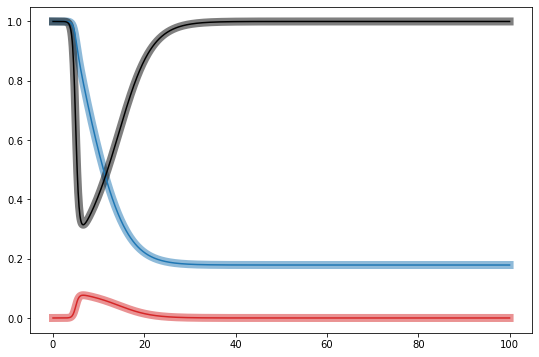

In [ ]:
def dasplague():
    (θfun,λfun,λbc,kfun),(constraint,payoff,salvage) = simon(a=lambda x : 400.0, f=1.0, β=1.0, kstar=4.0)

    times   = np.linspace(0, 100.0, num=1001)
    θ0, k0  = np.array([1-3e-8, 3e-8]), np.array(2.0)
    mixing  = mixfun(lambda k : np.clip(k, a_min=0.0), 0.1)
    kwargs  = {'times':times, 'x0':θ0, 'uguess':k0, 'mixing':mixing, 'state_interpolator':interp.vlinear, "control_interpolator":interp.linear, "unroll":True, "jit":True}

    (θg,λg,kg), gfuns = solver(f=θfun, g = λfun, gbc = λbc, control = kfun, **kwargs)
    (θ, λ, k ),  funs = generic_solver(LagrangeEquations=nashEL, V=payoff, W=salvage, F=constraint, **kwargs)
    
    fig,ax = plt.subplots(figsize=(9,6))
    ax.plot(times, θg[:,0], color='C0', lw=8, alpha=0.5)
    ax.plot(times, θg[:,1], color='C3', lw=8, alpha=0.5)
    ax.plot(times, kg/4, color='k', lw=8, alpha=0.5)
    ax.plot(times, θ[:,0], color='C0')
    ax.plot(times, θ[:,1], color='C3')
    ax.plot(times, k/4, color='k')

    print(f'δs = {maxerror(θ[:,0],θg[:,0]):.1e}')
    print(f'δi = {maxerror(θ[:,1],θg[:,1]):.1e}')
    print(f'δk = {maxerror(k, kg):.1e}')
dasplague()

Converged = True, Iterations =   84
δx = 6.2e-05
δu = 1.4e-04


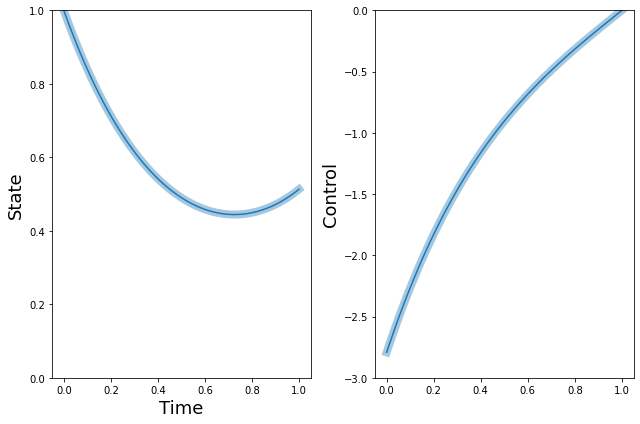

In [ ]:
# pg. 18
def example1_2(num=100):
    def F(t,x,u):
        return np.array(x + u)
    def V(t,x,u):
        return np.array(0.5*(3*x**2 + u**2))
    def W(t,x,u):
        return np.array(0.0)
    def gold(t):
        em4 = 3*np.exp(-4)
        ep2t,em2t = np.exp(2*t), np.exp(-2*t)

        return em4 / (em4 + 1)*ep2t + 1/(em4 + 1)*em2t, em4 / (em4 + 1)*ep2t - 3/(em4 + 1)*em2t
    
    times = np.linspace(0,1,num=num)
    x0,u0 = np.array(1.0), np.array(-1.0)
    (x,λ,u), _ = generic_solver(LagrangeEquations=constrainedEL(), V=V, W=W, F=F, times=times, x0=x0, uguess=u0, mixing=mixfun(lambda x:x, 0.1), \
                                state_interpolator=interp.linear, control_interpolator=interp.linear, unroll=True, jit=True)

    xg,ug = gold(times)
    print(f'δx = {maxerror(x,xg):.1e}')
    print(f'δu = {maxerror(u,ug):.1e}')

    fig,[ax,bx] = plt.subplots(figsize=(9,6),ncols=2, sharex=True)
    ax.plot(times, xg, lw=8, alpha=0.4, color='C0')
    ax.plot(times, x, color='C0')
    bx.plot(times, ug, lw=8, alpha=0.4, color='C0')
    bx.plot(times, u, color='C0')
    ax.set_ylim(0,1)
    bx.set_ylim(-3,0)
    ax.set_ylabel('State', fontsize=18)
    ax.set_xlabel('Time', fontsize=18)
    bx.set_ylabel('Control', fontsize=18)
    fig.tight_layout()
example1_2()

Converged = False, Iterations = 1000


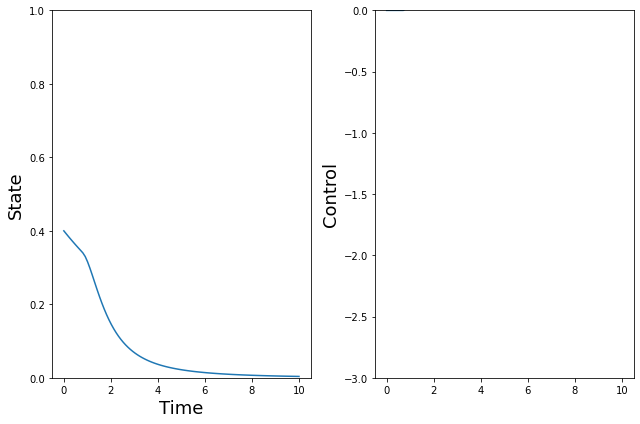

In [ ]:
def example_fish(num=100):
    def F(t,x,u):
        return np.array(-(0.2 + u)*x)
    def V(t,x,u):
        return np.array(5*(10*t)/(t+1)*x*u - u**2)
    def W(t,x,u):
        return np.array(0.0)
    
    times = np.linspace(0,10,num=num)
    x0,u0 = np.array(0.4), np.array(1.0)
    (x,λ,u), _ = generic_solver(LagrangeEquations=constrainedEL(), V=V, W=W, F=F, times=times, x0=x0, uguess=u0, mixing=mixfun(lambda u: np.clip(u, a_min=0.0,a_max=1.0), 0.1), \
                                state_interpolator=interp.linear, control_interpolator=interp.linear, unroll=True, jit=True)

    #print(f'δx = {maxerror(x,xg):.1e}')
    #print(f'δu = {maxerror(u,ug):.1e}')

    fig,[ax,bx] = plt.subplots(figsize=(9,6),ncols=2, sharex=True)
    ax.plot(times, x, color='C0')
    bx.plot(times, u, color='C0')
    ax.set_ylim(0,1)
    bx.set_ylim(-3,0)
    ax.set_ylabel('State', fontsize=18)
    ax.set_xlabel('Time', fontsize=18)
    bx.set_ylabel('Control', fontsize=18)
    fig.tight_layout()
example_fish()

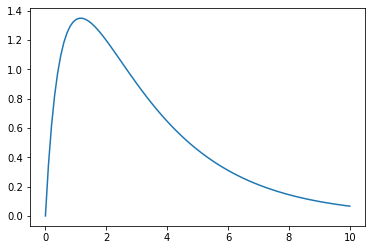

In [ ]:
times = np.linspace(0,10,num=100)
f_mass = lambda t: 10*t/(t+1)*0.4*np.exp(-0.4*t)
plt.plot(times,f_mass(times))

Converged = False, Iterations = 1000


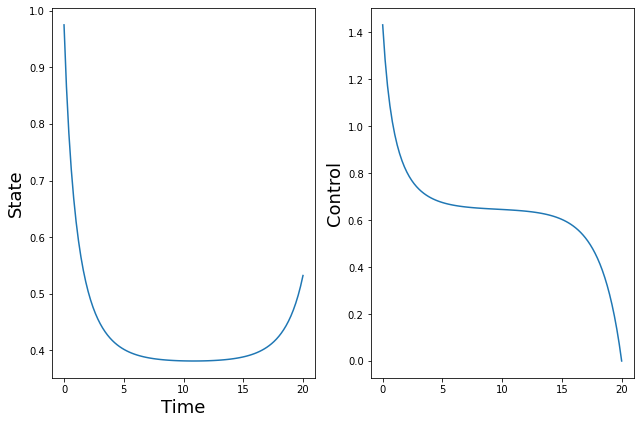

In [ ]:
def example_cancer(num=100):
    def F(t,x,u):
        return np.array(0.3*x*np.log(1/x)-u*0.45*x)
    def V(t,x,u):
        return np.array(3*x**2 + u**2)
    def W(t,x,u):
        return np.array(0.0)

    times = np.linspace(0,20,num=num)
    x0,u0 = np.array(0.975), np.array(1.0)
    (x,λ,u), _ = generic_solver(LagrangeEquations=constrainedEL(), V=V, W=W, F=F, times=times, x0=x0, uguess=u0, mixing=mixfun(lambda u: np.clip(u, a_min=0.0), 0.1), \
                                state_interpolator=interp.linear, control_interpolator=interp.linear, unroll=True, jit=True)
    
    fig,[ax,bx] = plt.subplots(figsize=(9,6),ncols=2, sharex=True)
    ax.plot(times, x, color='C0')
    bx.plot(times, u, color='C0')
    ax.set_ylabel('State', fontsize=18)
    ax.set_xlabel('Time', fontsize=18)
    bx.set_ylabel('Control', fontsize=18)
    fig.tight_layout()
example_cancer()

Converged = True, Iterations =    1


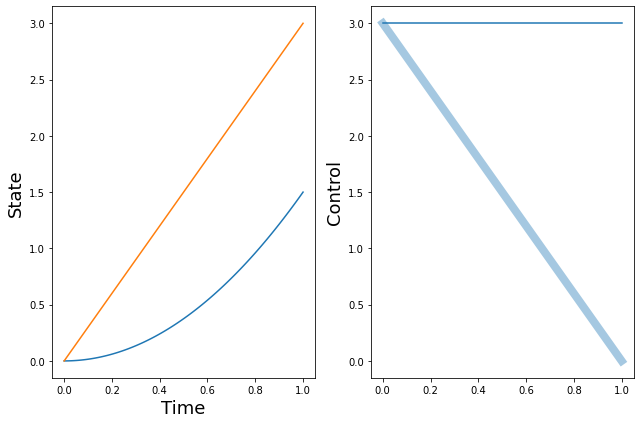

In [ ]:
def example_12_1(num=100):
    def F(t,x,u):
        return np.array([x[1],u])
    def V(t,x,u):
        return np.array(x[0] + x[1])
    def W(t,x,u):
        return np.array(0.0)

    times = np.linspace(0,1,num=num)
    x0,u0 = np.array([0.0,0.0]), np.array(3.0)
    (x,λ,u), _ = generic_solver(LagrangeEquations=constrainedEL(), V=V, W=W, F=F, times=times, x0=x0, uguess=u0, mixing=mixfun(lambda u: u, 0.1), \
                                state_interpolator=interp.vlinear, control_interpolator=interp.linear, unroll=True, jit=True)
    
    fig,[ax,bx] = plt.subplots(figsize=(9,6),ncols=2, sharex=True)
    ax.plot(times, x[:,0], color='C0')
    ax.plot(times, x[:,1], color='C1')
    bx.plot(times, u, color='C0')
    u_g = lambda t: 3-3*t
    bx.plot(times,u_g(times), lw=8, alpha=0.4, color='C0')
    ax.set_ylabel('State', fontsize=18)
    ax.set_xlabel('Time', fontsize=18)
    bx.set_ylabel('Control', fontsize=18)
    fig.tight_layout()
example_12_1()

Converged = False, Iterations = 1000


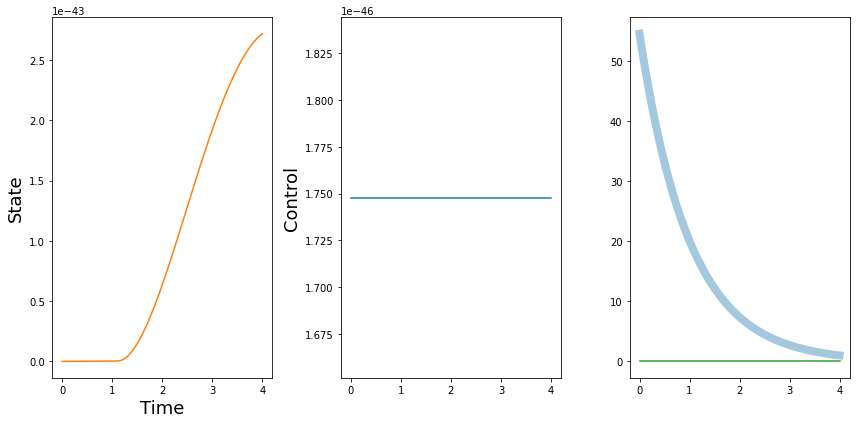

In [ ]:
def example_8_3(num=100):
    def F(t,x,u):
        return np.array(x + u)
    def V(t,x,u):
        return np.array(-u**2)
    def W(t,x,u):
        return np.array(-5/4+5*np.exp(-4))

    times = np.linspace(0,4,num=num)
    x0,u0 = np.array(0.0), np.array(1.0)
    (x,λ,u), _ = generic_solver(LagrangeEquations=constrainedEL(), V=V, W=W, F=F, times=times, x0=x0, uguess=u0, mixing=mixfun(lambda u: np.clip(u, a_max=5.0), 0.1), \
                                state_interpolator=interp.linear, control_interpolator=interp.linear, unroll=True, jit=True)
    
    fig,[ax,bx,cx] = plt.subplots(figsize=(12,6),ncols=3, sharex=True)
    ax.plot(times, x, color='C1')
    bx.plot(times, u, color='C0')
    ax.set_ylabel('State', fontsize=18)
    ax.set_xlabel('Time', fontsize=18)
    bx.set_ylabel('Control', fontsize=18)
    cx.plot(times,λ, color='C2')
    λ_t = lambda t:np.exp(4-t)
    cx.plot(times,λ_t(times), lw=8, alpha=0.4, color='C0')
    fig.tight_layout()
example_8_3()

/Users/john/opt/miniconda3/envs/forge/lib/python3.9/site-packages/jax/_src/tree_util.py:188: FutureWarning: jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() instead as a drop-in replacement.
  warnings.warn('jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() '


Converged = True, Iterations =   53
δx = 8.6e-04
δu = 3.6e-03


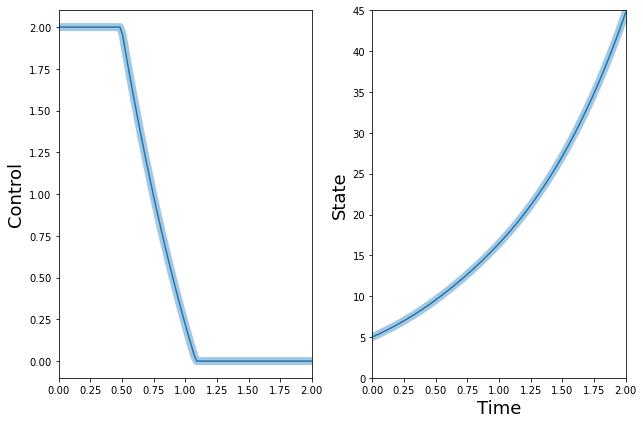

In [ ]:
#pg. 77
def example8_2(num=100):
    def F(t,x,u):
        return np.array(x + u)
    def V(t,x,u):
        return np.array(2*x-3*u-u**2)
    def W(t,x,u):
        return np.array(0.0)
    def gold(t):
        over  = np.logical_and(t >= 0.0, t < 2 - np.log(9/2))
        under = np.logical_and(t > 2 - np.log(5/2), t <= 2)
        x = (7-81/8*np.exp(-2))*np.exp(t) - 1/2*np.exp(2-t) + 5/2
        u = np.exp(2-t) - 5/2
        x = x.at[over].set(7*np.exp(t[over]) - 2)
        u = u.at[over].set(2)
        x = x.at[under].set((7-7*np.exp(-2))*np.exp(t[under]))
        u = u.at[under].set(0.0)
        return x, u
    
    times = np.linspace(0,2,num=num)
    x0,u0 = np.array(5.0), np.array(1.0)
    (x,λ,u), _ = generic_solver(LagrangeEquations=constrainedEL(), V=V, W=W, F=F, times=times, x0=x0, uguess=u0, mixing=mixfun(lambda u: np.clip(u, a_min=0.0, a_max=2.0), 0.1), \
                                state_interpolator=interp.linear, control_interpolator=interp.linear, unroll=True, jit=True)

    xg,ug = gold(times)
    print(f'δx = {maxerror(x,xg):.1e}')
    print(f'δu = {maxerror(u,ug):.1e}')

    fig,[bx,ax] = plt.subplots(figsize=(9,6),ncols=2, sharex=True)
    ax.plot(times, xg, lw=8, alpha=0.4, color='C0')
    ax.plot(times, x, color='C0')
    bx.plot(times, ug, lw=8, alpha=0.4, color='C0')
    bx.plot(times, u, color='C0')
    ax.set_xlim(0,2)
    ax.set_ylim(0,45)
    ax.set_ylabel('State', fontsize=18)
    ax.set_xlabel('Time', fontsize=18)
    bx.set_ylabel('Control', fontsize=18)
    fig.tight_layout()
example8_2()

/Users/john/opt/miniconda3/envs/forge/lib/python3.9/site-packages/jax/_src/tree_util.py:188: FutureWarning: jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() instead as a drop-in replacement.
  warnings.warn('jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() '


Converged = True, Iterations =   89
δx = 6.8e-05
δu = 4.6e-05


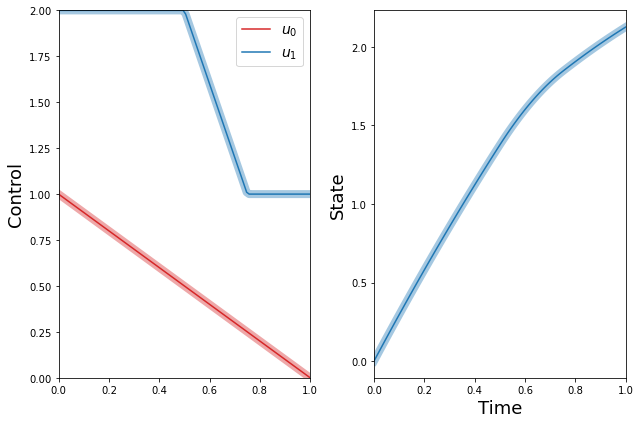

In [ ]:
#pg. 101
def example12_2(num=100):
    def F(t,x,u):
        u1,u2 = u
        return np.array(u1+u2)
    def V(t,x,u):
        u1,u2 = u
        return np.array(x - 1/8*u1**2 - 1/2*u2**2)
    def W(t,x,u):
        return np.array(0.0)
    def gold(t):
        over  = np.logical_and(t >= 0, t < 1/2)
        under = np.logical_and(t > 3/4, t <= 1)
        x  = 5*t - 5/2*t**2 - 1/2
        u1 = 4-4*t
        u2 = 1 - t
        x = x.at[over].set(3*t[over] - 1/2*t[over]**2)
        x = x.at[under].set(2*t[under] - 1/2*t[under]**2 + 5/8)
        u1 = u1.at[over].set(2.0)
        u1 = u1.at[under].set(1.0)
        return x, np.stack([u1,u2], axis=-1)
    def umix(u):
        return np.stack([np.clip(u[...,0], a_min=1.0, a_max=2.0), u[...,1]], axis=-1)    

    times = np.linspace(0,1,num=num)
    x0,u0 = np.array(0.0), np.array([1.5, 0.5])
    (x,λ,u), _ = generic_solver(LagrangeEquations=constrainedEL(), V=V, W=W, F=F, times=times, x0=x0, uguess=u0, mixing=mixfun(umix, 0.1), \
                                state_interpolator=interp.linear, control_interpolator=interp.vlinear, unroll=True, jit=True)
    xg,ug = gold(times)
    print(f'δx = {maxerror(x,xg):.1e}')
    print(f'δu = {maxerror(u,ug):.1e}')

    fig,[bx,ax] = plt.subplots(figsize=(9,6),ncols=2, sharex=True)
    ax.plot(times, xg, lw=8, alpha=0.4, color='C0')
    ax.plot(times, x, color='C0')
    bx.plot(times, ug[:,0], lw=8, alpha=0.4, color='C0')
    bx.plot(times, ug[:,1], lw=8, alpha=0.4, color='C3')
    bx.plot(times, u[:,1], color='C3', label='$u_0$')
    bx.plot(times, u[:,0], color='C0', label='$u_1$')
    ax.set_xlim(0,1)
    bx.set_ylim(0,2)
    bx.legend(fontsize=14)
    ax.set_ylabel('State', fontsize=18)
    ax.set_xlabel('Time', fontsize=18)
    bx.set_ylabel('Control', fontsize=18)
    fig.tight_layout()
example12_2()

In [143]:
def inno(r,a1,a2,a,α,β,μ,ξ,b1,b2,δ,σ,T,q0,c0,A10,A20,num=100):
    def F(t,x,u):
        p,k,h = u
        q,c = x
        return np.array([k*q - δ*q, -h*c + σ*c])
    def V(t,x,u):
        p,k,h = u
        q,c = x
        return np.array((p-c)*(a - a1*p + a2*q)- α*k**2 - β*h**2 )
    def W(t,x,u):
        return np.array(0.0)

    def umix(u):
        return np.stack([np.clip(u[...,0], a_min=10.0), np.clip(u[...,1], a_min=0.0, a_max=3.0), np.clip(u[...,2], a_min=0.0,a_max=7.0)], axis=-1)  

    times = np.linspace(0,T,num=num)
    x0,u0 = np.array([q0, c0]), np.array([27.0, 1.1, 0.1])
    (x,λ,u), _ = generic_solver(LagrangeEquations=constrainedEL(), V=V, W=W, F=F, times=times, x0=x0, uguess=u0, mixing=mixfun(umix, 0.03), \
                                state_interpolator=interp.vlinear, control_interpolator=interp.vlinear, unroll=True, jit=True)
    return x,λ,u,times

In [144]:
x,λ,u,times = inno(0.08,2.8,2.2,50.0,3.2,3.0,3.0,3.2,2.0,3.8,0.1,0.12,10,10.0,30.0,5.0,1.0)

Converged = True, Iterations =    3


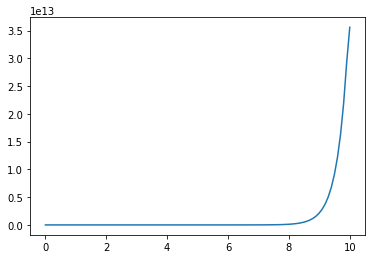

In [145]:
#quality
plt.plot(times,x[:,0])

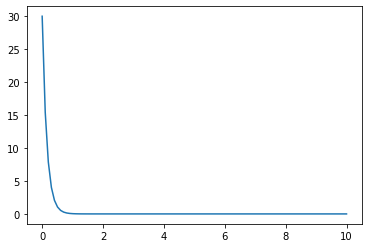

In [146]:
#cost
plt.plot(times,x[:,1])

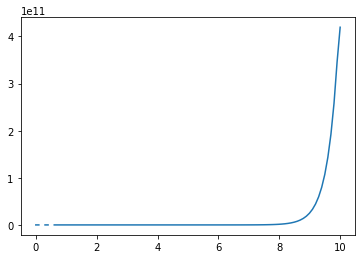

In [147]:
#product price
plt.plot(times,u[:,0])

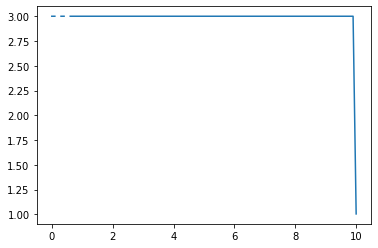

In [148]:
#product innovation investmet
plt.plot(times,u[:,1])

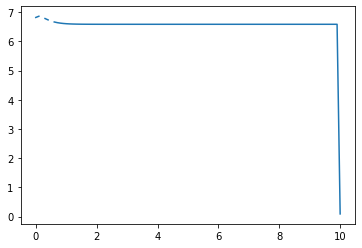

In [149]:
#process innovation investmet
plt.plot(times,u[:,2])

In [162]:
from jax.experimental.ode import odeint

def dfdt(u,t):
  r = 0.08
  a1 = 2.8
  a2 = 2.2
  a = 50.0
  α = 3.2
  β = 3.0
  μ = 3.0
  ξ = 3.2
  b1 = 2.0
  b2 = 3.8
  δ = 0.1
  σ = 0.12
  T = 10
  k,h,q,c = u
  dkdt = (4*α*a1*(r+δ)*k + a1*a2*c - a2**2*q - a*a2 - 2*μ*a1*b1*(1+δ*(1-np.exp(r*(t-T))/r)))/(4*α*a1)
  dhdt = (-a + 4*β*(r-σ)*h + a1*c -a2*q - 2*ξ*b2*(1-σ*(1-np.exp(r*(t-T))/r)))/(4*β)
  dqdt = k - δ*q
  dcdt = -h + σ*c
  return [dkdt,dhdt,dqdt,dcdt]

times = np.linspace(0,10,num=100)

In [191]:
def dfdt2(u,t):
  k,h,q,c,A1,A2 = u
  b1 = 2
  b2 = 3.8
  r = 0.05
  T = 10
  dkdt = -4.01 + 0.1719*c + 0.18*k - 0.135*q - 0.0469*(1-np.exp(r*(t-T)))*b1/r
  dhdt = -6.193 + 0.233*c - 0.04*h - 0.183*q + 0.064*(1-np.exp(r*(t-T)))*b2/r
  dqdt = k -0.1*q
  dcdt = -h + 0.12*c
  dA1dt = 3*k
  dA2dt = 3.2*h
  return [dkdt,dhdt,dqdt,dcdt,dA1dt,dA2dt]

In [214]:
A_s = odeint(dfdt2,np.array([1.1,0.0,10.0,30.0,1.0,1.0]),times)
A_s.shape

(100, 6)

In [215]:
p = (50 + 2.8*A_s[:,3] + 2.2*A_s[:,2])/(2*2.8)

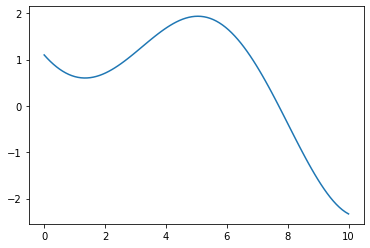

In [216]:
plt.plot(times,A_s[:,0])

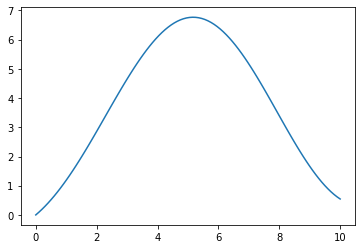

In [217]:
plt.plot(times,A_s[:,1])

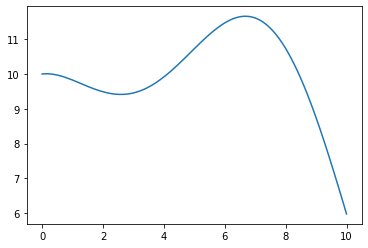

In [196]:
plt.plot(times,A_s[:,2])

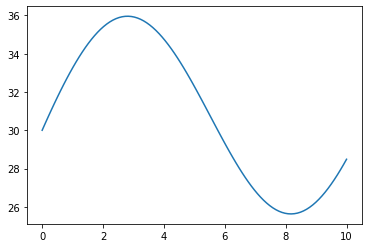

In [197]:
plt.plot(times,A_s[:,3])

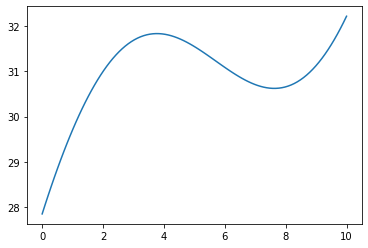

In [213]:
plt.plot(times,p)

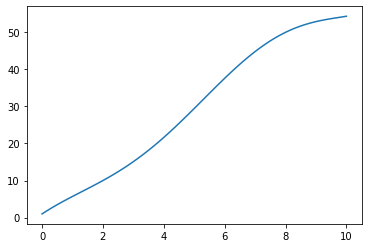

In [211]:
plt.plot(times,A_s[:,4])

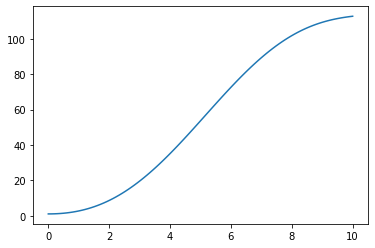

In [212]:
plt.plot(times,A_s[:,5])